In [1]:
import numpy as np
from numba import jit
from numba.experimental import jitclass
from abc import ABC, abstractmethod
from typing import List, Union, Dict
import matplotlib.pyplot as plt
plt.style.use('dark_background')

In [2]:
# this can be compiled
@jit(nopython=True)
def hmm_forward(prob, A, P):
    '''
    Forward algorithm for the HMM
    prob: numpy (n,n_states) array with
        the probability of each observation
        for each state
    A: numpy (n_states,n_states) array with the state
        transition matrix
    P: numpy (n_states,) array with the initial
        state probability
    returns:
        alpha: numpy (n,n_states) array meaning
            p(state=i|obs <= i)
        c: numpy (n,) array with the normalization
            constants
    '''
    n_obs = prob.shape[0]
    n_states = prob.shape[1]
    alpha = np.zeros((n_obs,n_states), dtype = np.float64)
    c = np.zeros(n_obs, dtype = np.float64)
    alpha[0] = P*prob[0]
    c[0] = 1 / np.sum(alpha[0])
    alpha[0] *= c[0]
    for i in range(1, n_obs):
        alpha[i] = np.dot(A.T, alpha[i-1]) * prob[i] 
        c[i] = 1 / np.sum(alpha[i])
        alpha[i] *= c[i]
    return alpha, c

# this can be compiled
@jit(nopython=True)
def hmm_backward_sample(A, alpha, z, transition_counter, init_state_counter):
    '''
    Backward sample from the state transition matrix and state sequence
    A: numpy (n_states,n_states) array with the state
        transition matrix
    alpha: numpy (n,n_states) array meaning
        p(state=i|obs <= i)		
    z: numpy (n,) to store the sample of state sequence
    transition_counter: numpy (n_states,n_states) array to store 
        transition counts to be used to sample a state transition 
        matrix
    init_state_counter: numpy (n_states,) array to store the
        number of times state i is the initial one
    returns:
        none (q and transition_counter are changed inside this function)
    '''	
    # backward walk to sample from the state sequence
    n = z.size
    # sample the last hidden state with probability alpha[-1]
    z[n-1] = np.searchsorted(np.cumsum(alpha[-1]), np.random.random(), side = "right")
    # aux variable
    p = np.zeros(A.shape[0], dtype = np.float64)
    # iterate backwards
    for j in range(n-2, -1, -1):
        # from formula
        p = A[:,z[j+1]] * alpha[j] 
        # normalize (from formula)
        p /= np.sum(p) 
        # sample hidden state with probability p
        z[j] = np.searchsorted(np.cumsum(p), np.random.random(), side="right")
        # increment transition counter (we can do this calculation incrementally)
        transition_counter[z[j],z[j+1]] += 1 
    # increment initial state counter
    init_state_counter[z[0]] += 1


In [3]:
class uEmission(ABC):

    def set_gibbs_parameters(self, n_gibbs, f_burn, n_gibbs_sim = None):
        self.n_gibbs = n_gibbs
        self.f_burn = f_burn
        aux = int(self.n_gibbs*(1+self.f_burn))
        self.n_gibbs_sim = aux if n_gibbs_sim is None else n_gibbs_sim

    @abstractmethod
    def view(self, plot_hist:bool = False):
        """Subclasses must implement this method"""
        pass
            
    @abstractmethod
    def gibbs_initialize(self, y:np.ndarray, x:np.ndarray = None, **kwargs):
        """Subclasses must implement this method"""
        pass

    @abstractmethod
    def gibbs_posterior_sample(self, y:np.ndarray, x:np.ndarray, iteration:int, **kwargs):
        """Subclasses must implement this method"""
        pass

    @abstractmethod
    def gibbs_burn_and_mean(self):
        """Subclasses must implement this method"""
        pass

    @abstractmethod
    def gibbs_prob(self, y:np.ndarray, x:np.ndarray, iteration:int, **kwargs):
        """Subclasses must implement this method"""
        pass

    @abstractmethod
    def prob(self, y:np.ndarray, x:np.ndarray, **kwargs):
        """Subclasses must implement this method"""
        pass

    @abstractmethod
    def posterior_predictive(self, xq:np.ndarray, **kwargs):
        """Subclasses must implement this method"""
        pass
    
    @abstractmethod
    def predict_pi(self, xq:np.ndarray, **kwargs):
        """Subclasses must implement this method"""
        pass


In [4]:
# univariate HMM

class uHMM(object):
    def __init__(
                self,
                emissions:List[uEmission] = [],
                n_gibbs = 1000,
                A_zeros = [],
                emissions_indexes = [],
                f_burn = 0.1,
                pred_l = None,
                **kwargs
                ):
        '''
        emissions: list of instances derived from Emission
                one for each state
        n_gibbs: number of gibbs samples
        A_zeros: list of lists with entries of A to be set to zero
        emissions_indexes: list of lists
            example
                    emissions_indexes = [[0,2],[1,3]]
                means 
                    emission[0] is applied to states 0 and 2
                    emission[1] is applied to states 1 and 3
                also, this implies that the number of states is 4!
        f_burn: fraction to burn  
        '''
        self.emissions = emissions   
        self.n_gibbs = n_gibbs
        self.f_burn = f_burn
        self.A_zeros = A_zeros
        self.emissions_indexes = emissions_indexes 
        if len(self.emissions_indexes) == 0:
            self.n_states = len(self.emissions)
            self.emissions_indexes = [[e] for e in range(self.n_states)]   
        self.n_states = 0 
        for e in self.emissions_indexes: self.n_states += len(e)
        self.n_emissions = len(self.emissions)
        assert len(self.emissions_indexes) == self.n_emissions, "emissions do not match groups"
        # real number of samples to simulate
        self.n_gibbs_sim = int(self.n_gibbs*(1+self.f_burn))
        self.pred_l = None
        self.P = None
        self.gibbs_P = None
        self.A = None
        self.gibbs_A = None
        self.w_norm = 1
        # **
        for emission in self.emissions:
            emission.set_gibbs_parameters(self.n_gibbs, self.f_burn, self.n_gibbs_sim)
        # **
        # Dirichelet prior parameters
        self.ALPHA = 1
        self.ZERO_ALPHA = 0.001
        self.ALPHA_P = 0.05 
        # A initial mass (persistency)
        self.INIT_MASS = 0.9

    def view(self, plot_hist = False):
        '''
        plot_hist: if true, plot histograms, otherwise just show the parameters
        '''
        print('** HMM **')
        print('Groups')
        for e in self.emissions_indexes:
            print('States %s have the same emission'%','.join([str(a) for a in e]))
        print('Initial state probability')
        print(self.P)
        if plot_hist:
            for i in range(self.n_states):
                plt.hist(self.gibbs_P[:,i], density=True, alpha=0.5, label='P[%s]'%(i))
            plt.legend()
            plt.grid(True)
            plt.show()
        print('State transition matrix')
        print(np.round(self.A,3))
        print()
        if plot_hist:
            for i in range(self.n_states):
                for j in range(self.n_states):
                    if [i,j] not in self.A_zeros:
                        plt.hist(
                                self.gibbs_A[:,i,j],
                                density=True,
                                alpha=0.5,
                                label='A[%s->%s]'%(i,j)
                                )
            plt.legend()
            plt.grid(True)
            plt.show()
        for s, emission in enumerate(self.emissions):
            print(f'HMM Emission {s}')
            emission.view(plot_hist = plot_hist)

    def transitions_dirichlet_priors(self):
        alphas = []
        for s in range(self.n_states):
            tmp = self.ALPHA*np.ones(self.n_states)
            for e in self.A_zeros:
                if e[0] == s:
                    tmp[e[1]] = self.ZERO_ALPHA
            alphas.append(tmp)
        return alphas
    
    def estimate(self, y:np.ndarray, x:np.ndarray = None, idx = None, **kwargs):	 
        if y.ndim == 2:
            assert y.shape[1] == 1, "y must contain a single series"
            y = y[:,0]        
        assert y.ndim == 1, "y must be a vector"
        if x is not None:             
            assert x.ndim == 2,"x must be a matrix"
            assert y.size == x.shape[0], "x and y must have the same number of observations"
        # **
        # number of observations
        n = y.size
        # idx for multisequence
        if idx is None:
            idx = np.array([[0,n]], dtype = int)
        # convert to integer to make sure this is well defined
        idx = np.array(idx, dtype = int)
        # number of sequences
        n_seqs = idx.shape[0]
        # **
        # **
        # Dirichlet prior
        A_alphas = self.transitions_dirichlet_priors()
        # **
        # **
        # Containers
        # counter for state transitions
        transition_counter = np.zeros((self.n_states, self.n_states)) 
        # counter for initial state observations
        init_state_counter = np.zeros(self.n_states) 
        # # forward alpha
        # forward_alpha = np.zeros((n,self.n_states), dtype = np.float64)
        # # forward normalization variable
        # forward_c = np.zeros(n, dtype = np.float64)
        # probability of observation given state
        prob = np.zeros((n,self.n_states), dtype = np.float64)         
        # transition matrix samples
        self.gibbs_A = np.zeros((self.n_gibbs_sim, self.n_states, self.n_states)) 
        # initial state probability samples
        self.gibbs_P = np.zeros((self.n_gibbs_sim, self.n_states))
        
        # ** 
        # **
        # Initialize
        # Transition matrix A
        # assume some persistency of state as a initial parameter
        tmp = self.INIT_MASS * np.eye(self.n_states)
        remaining_mass = (1-self.INIT_MASS) / (self.n_states - 1)
        tmp[tmp == 0] = remaining_mass	
        # set zeros
        for e in self.A_zeros:
            tmp[e[0],e[1]] = 0
        # normalize
        tmp /= np.sum(tmp,axis=1)[:,None]
        self.gibbs_A[0] = tmp
        
        # Initial State Distribution
        self.gibbs_P[0] = np.ones(self.n_states)
        self.gibbs_P[0] /= np.sum(self.gibbs_P[0])		
        # initialize emissions
        for emission in self.emissions:
            emission.gibbs_initialize(y = y, x = x)
        # **

        # **
        # create and initialize variable with
        # the states associated with each variable
        # assume equal probability in states
        z = np.random.choice(np.arange(self.n_states, dtype = int), size = n)
        # **

        # Gibbs sampler
        for i in range(1, self.n_gibbs_sim):
            # **
            # set counters to zero
            transition_counter *= 0 
            init_state_counter *= 0 
            # **
            # evaluate the probability of each observation
            for s in range(self.n_emissions):
                prob[:,self.emissions_indexes[s]] = self.emissions[s].gibbs_prob(
                                                                                y = y, 
                                                                                x = x, 
                                                                                iteration = i
                                                                                )[:,None]
            # **
            # sample form hidden state variable
            for l in range(n_seqs):
                # compute alpha variable
                forward_alpha, _ = hmm_forward(
                                        prob[idx[l][0]:idx[l][1]],
                                        self.gibbs_A[i-1],
                                        self.gibbs_P[i-1]
                                        )
                # backward walk to sample from the state sequence
                hmm_backward_sample(
                                    self.gibbs_A[i-1],
                                    forward_alpha,
                                    z[idx[l][0]:idx[l][1]],
                                    transition_counter,
                                    init_state_counter
                                    )
            # **
            # sample from transition matrix
            for s in range(self.n_states):
                self.gibbs_A[i,s] = np.random.dirichlet(A_alphas[s] + transition_counter[s])
            # make sure that the entries are zero!
            for A_zero in self.A_zeros:
                self.gibbs_A[i, A_zero[0], A_zero[1]] = 0.
            # normalize 
            self.gibbs_A[i] /= np.sum(self.gibbs_A[i],axis=1)[:,None]
            # **
            # sample from initial state distribution
            self.gibbs_P[i] = np.random.dirichlet(self.ALPHA_P + init_state_counter)   
            # perform the gibbs step with the state sequence sample q
            for s in range(self.n_emissions):
                idx_states = np.where(np.in1d(z, self.emissions_indexes[s]))[0]
                self.emissions[s].gibbs_posterior_sample(
                                                        y = y[idx_states],
                                                        x = None if x is None else x[idx_states],
                                                        iteration = i
                                                        )

        # burn observations
        self.gibbs_A = self.gibbs_A[-self.n_gibbs:]
        self.gibbs_P = self.gibbs_P[-self.n_gibbs:]
        for emission in self.emissions:
            emission.gibbs_burn_and_mean()
        # take mean
        self.A = np.mean(self.gibbs_A, axis = 0)
        self.P = np.mean(self.gibbs_P, axis = 0)
        # normalization constant
        self.w_norm = 0
        for s in range(self.n_emissions):
            self.w_norm = max(self.w_norm, self.emissions[s].w_norm)
        if self.w_norm == 0: self.w_norm = 1

    def next_state_prob(self, y:np.ndarray, x:np.ndarray = None, l:int = None):
        '''
        computes a vector with the next state probability
        given a input sequence
        xyq: numpy (n,self.p) array with observation
        l: integer to filter recent data in y -> y=y[-l:]
        '''
        if y.ndim == 2:
            assert y.shape[1] == 1, "y must contain a single series"
            y = y[:,0]        
        assert y.ndim == 1, "y must be a vector"
        if x is not None:             
            assert x.ndim == 2,"x must be a matrix"
            assert y.size == x.shape[0], "x and y must have the same number of observations"
        # just return the initial state probability 
        if y.size == 0:
            return self.P
        if l is not None:
            y = y[-l:]
            if x is not None: x = x[-l:]
        n = y.size
        prob = np.zeros((n, self.n_states), dtype = np.float64) 
        # evaluate the probability of each observation
        for s in range(self.n_emissions):
            prob[:,self.emissions_indexes[s]] = self.emissions[s].prob(
                                                                        y = y, 
                                                                        x = x,
                                                                        )[:,None] 
        alpha, _ = hmm_forward(prob, self.A, self.P)
        next_state_prob = np.dot(self.A.T, alpha[-1])  
        return next_state_prob	

    def get_weight(
                self, 
                y:np.ndarray, 
                x:np.ndarray = None, 
                xq:np.ndarray = None, 
                normalize = True, 
                **kwargs
                ):
        '''
        compute betting weight given an input sequence
        y: numpy (n,p) array with a sequence
            each point is a joint observations of the variables
        l: integer to filter recent data in y -> y=y[-l:]
        returns:
            w: numpy (p,) array with weights to allocate to each asset
            in y
        '''

        # next state probability for all states
        next_state_prob_ = self.next_state_prob(y, x, self.pred_l)
        # group next state prob
        next_state_prob = np.zeros(self.n_emissions)
        for s, e in enumerate(self.emissions_indexes):
            next_state_prob[s] = np.sum(next_state_prob_[e])

        # correct weighting of predicitve mixture in case
        # the hidden states have predictors
        for s in range(self.n_emissions):
             next_state_prob[s] *= self.emissions[s].predict_pi(xq = xq)
        next_state_prob /= np.sum(next_state_prob)

        # build the mixture
        mixture_mean = 0
        mixture_var = 0
        for s in range(self.n_emissions):
            mean, var = self.emissions[s].posterior_predictive(xq = xq)
            mixture_mean += next_state_prob[s]*mean
            mixture_var += next_state_prob[s]*(var + mean*mean)
        mixture_var -= mixture_mean*mixture_mean
        w = mixture_mean / mixture_var
        if normalize:
            w /= self.w_norm
        return np.atleast_1d(w)
    

** Univariate Gaussian Emission **
Mean
-0.9719631577840905
Variance
0.47563850372362243



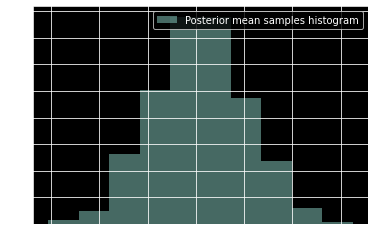

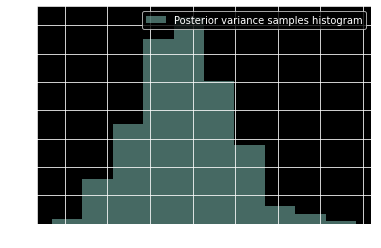

In [5]:
# univariate gaussian
class uGaussianEmission(uEmission):
    def __init__(self, n_gibbs:int = 1000, f_burn:float = 0.1, min_points_update = 5):
        
        self.n_gibbs = n_gibbs
        self.f_burn = f_burn
        self.n_gibbs_sim = int(self.n_gibbs*(1+self.f_burn))
        self.min_points_update = min_points_update
        # variables to be computed
        self.var = None
        self.mean = None        
        self.S0aux = None
        self.invV0, self.invV0m0 = None, None
        self.prev_mn, self.prev_Vn = None, None
        self.prev_vn, self.prev_Sn = None, None 
    
    def get_pdf_limits(self, k = 5):
        return self.mean - 5*np.sqrt(self.var), self.mean + 5*np.sqrt(self.var)
    
    def pdf(self, x):
        return np.exp(-0.5*np.power(x-self.mean,2)/self.var)/np.sqrt(2*np.pi*self.var)
        
    def view(self, plot_hist = False):
        print('** Univariate Gaussian Emission **')
        print('Mean')
        print(self.mean)
        print('Variance')
        print(self.var)
        print()
        if plot_hist:
            if self.gibbs_mean is not None:
                plt.hist(
                        self.gibbs_mean,
                        density=True,
                        alpha=0.5,
                        label='Posterior mean samples histogram'
                        )
                plt.legend()
                plt.grid(True)
                plt.show()
            if self.gibbs_var is not None:
                plt.hist(
                        self.gibbs_var,
                        density=True,
                        alpha=0.5,
                        label='Posterior variance samples histogram'
                        )
                plt.legend()
                plt.grid(True)
                plt.show()

    def gibbs_initialize(self, y, **kwargs):
        assert y.ndim == 1, "y must be a vector"
        # this will be updated later
        self.mean = 0         
        # Covariance samples
        self.gibbs_var = np.zeros(self.n_gibbs_sim) 
        # Mean samples
        self.gibbs_mean = np.zeros(self.n_gibbs_sim)          
        # compute data variance
        self.var = np.var(y)
        # Prior distribution parameters
        self.m0 = 0 # np.mean(y) # mean: prior location (just put it at zero...)
        self.v0 = self.var # mean: prior covariance        
        self.a0 = 2 # infinite variance...
        self.b0 = self.var        
        # initialize
        self.gibbs_mean[0] = self.m0
        self.gibbs_var[0] = self.var
        # store parameters
        self.prev_mn = self.m0
        self.prev_vn = self.v0
        self.prev_an = self.a0
        self.prev_bn = self.b0

    def gibbs_posterior_sample(self, y:np.ndarray, iteration:int, **kwargs):
        '''
        y: current set of observations
        to be called while in sampler
        '''
        assert y.ndim == 1, "y must be a vector"
        assert 0<iteration<self.n_gibbs_sim, "iteration is larger than the number of iterations"
        # no observations in y
        if y.size < self.min_points_update:
            self.gibbs_mean[iteration] = np.random.normal(self.prev_mn, self.prev_vn)
            self.gibbs_var[iteration] = 1 / np.random.gamma(self.prev_an, 1 / self.prev_bn)
        else:
            n = y.size
            y_sum = np.sum(y)            
            # Sample from mean
            mn = (self.m0*self.gibbs_var[iteration-1] + self.v0*y_sum)
            mn /= (n*self.v0 + self.gibbs_var[iteration-1])            
            vn = self.gibbs_var[iteration-1] * self.v0 / (n*self.v0 + self.gibbs_var[iteration-1])
            self.prev_mn = mn
            self.prev_vn = vn
            self.gibbs_mean[iteration] = np.random.normal(mn, vn)
            # Sample from variance
            an = self.a0 + n/2
            bn = self.b0 + 0.5*np.sum(np.power(y-y_sum/n,2))
            self.prev_an = an
            self.prev_bn = bn
            self.gibbs_var[iteration] = 1 / np.random.gamma(an, 1 / bn)	

    def gibbs_burn_and_mean(self):
        self.gibbs_mean = self.gibbs_mean[-self.n_gibbs:]
        self.gibbs_var = self.gibbs_var[-self.n_gibbs:]		
        self.mean = np.mean(self.gibbs_mean)
        self.var = np.mean(self.gibbs_var)	
        self.w_norm = np.abs(self.mean / self.var) # betting weight
    
    def gibbs_prob(self, y:np.ndarray, iteration:int, **kwargs):
        assert 0<iteration<self.n_gibbs_sim, "iteration is larger than the number of iterations"
        assert y.ndim == 1, "y must be a vector"
        p = np.exp(-0.5*np.power(y-self.gibbs_mean[iteration-1],2)/self.gibbs_var[iteration-1])
        p /= np.sqrt(2*np.pi*self.gibbs_var[iteration-1])
        return p
    
    def estimate(self, y:np.ndarray, **kwargs):
        # cycle to test individually the inference!
        self.gibbs_initialize(y)
        for i in range(1, self.n_gibbs_sim):
            self.gibbs_posterior_sample(y, i)
        self.gibbs_burn_and_mean()		
    
    def prob(self, y:np.ndarray,  **kwargs):
        # use vectorized function
        assert y.ndim == 1, "y must be a vector"
        return np.exp(-0.5 * np.power(y - self.mean, 2) / self.var) / np.sqrt(2*np.pi*self.var)
    
    def posterior_predictive(self, **kwargs):
        return self.mean, self.var
    
    def predict_pi(self, **kwargs):
        return 1
    
# run bayesian inference
y = np.random.normal(-1, np.sqrt(0.5), 1000)
g = uGaussianEmission()
g.estimate(y)
g.view(True)

** Univariate Gaussian Emission **
Mean
-0.9536314057115266
Variance
0.473254419566572



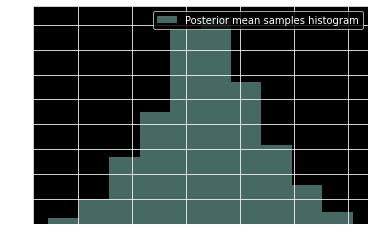

In [6]:
# univariate gaussian
class uGaussianMeanEmission(uEmission):
    
    __slots__ = [
                'n_gibbs', 
                'f_burn',
                'n_gibbs_sim',
                'min_points_update',
                'var',
                'mean',
                'gibbs_mean',
                'm0',
                'v0'
                'w_norm'
    ]  
    
    def __init__(self, n_gibbs:int = 1000, f_burn:float = 0.1, min_points_update = 5):
        
        self.n_gibbs = n_gibbs
        self.f_burn = f_burn
        self.n_gibbs_sim = int(self.n_gibbs*(1+self.f_burn))
        self.min_points_update = min_points_update
        # variables to be computed
        self.var = None
        self.mean = None   
        
    def get_pdf_limits(self, k = 5):
        return self.mean - 5*np.sqrt(self.var), self.mean + 5*np.sqrt(self.var)
    
    def pdf(self, x):
        return np.exp(-0.5*np.power(x-self.mean,2)/self.var)/np.sqrt(2*np.pi*self.var)
        
    def view(self, plot_hist = False):
        print('** Univariate Gaussian Emission **')
        print('Mean')
        print(self.mean)
        print('Variance')
        print(self.var)
        print()
        if plot_hist:
            if self.gibbs_mean is not None:
                plt.hist(
                        self.gibbs_mean,
                        density=True,
                        alpha=0.5,
                        label='Posterior mean samples histogram'
                        )
                plt.legend()
                plt.grid(True)
                plt.show()


    def gibbs_initialize(self, y, **kwargs):
        assert y.ndim == 1, "y must be a vector"
        # this will be updated later
        self.mean = 0         
        # Mean samples
        self.gibbs_mean = np.zeros(self.n_gibbs_sim)          
        # compute data variance
        self.var = np.var(y)
        # Prior distribution parameters
        self.m0 = 0 # np.mean(y) # mean: prior location (just put it at zero...)
        self.v0 = self.var # mean: prior covariance          
        # initialize
        self.gibbs_mean[0] = self.m0

    def gibbs_posterior_sample(self, y:np.ndarray, iteration:int, **kwargs):
        '''
        y: current set of observations
        to be called while in sampler
        '''
        assert y.ndim == 1, "y must be a vector"
        assert 0<iteration<self.n_gibbs_sim, "iteration is larger than the number of iterations"
        # no observations in y
        if y.size < self.min_points_update:
            self.gibbs_mean[iteration] = np.random.normal(self.m0, self.v0)
        else:
            n = y.size
            # y_sum = np.sum(y)            
            # Sample from mean
            mn = np.mean(y)#(self.m0*self.var + self.v0*y_sum)
            # mn /= (n*self.v0 + self.var)            
            vn = 1/n # self.var * self.v0 / (n*self.v0 + self.var)
            self.prev_mn = mn
            self.prev_vn = vn
            self.gibbs_mean[iteration] = np.random.normal(mn, vn)

    def gibbs_burn_and_mean(self):
        self.gibbs_mean = self.gibbs_mean[-self.n_gibbs:]
        self.mean = np.mean(self.gibbs_mean)
        self.w_norm = np.abs(self.mean / self.var) # betting weight
    
    def gibbs_prob(self, y:np.ndarray, iteration:int, **kwargs):
        assert 0<iteration<self.n_gibbs_sim, "iteration is larger than the number of iterations"
        assert y.ndim == 1, "y must be a vector"
        p = np.exp(-0.5*np.power(y-self.gibbs_mean[iteration-1],2)/self.var)
        p /= np.sqrt(2*np.pi*self.var)
        return p
    
    def estimate(self, y:np.ndarray, **kwargs):
        # cycle to test individually the inference!
        self.gibbs_initialize(y)
        for i in range(1, self.n_gibbs_sim):
            self.gibbs_posterior_sample(y, i)
        self.gibbs_burn_and_mean()		
    
    def prob(self, y:np.ndarray,  **kwargs):
        # use vectorized function
        assert y.ndim == 1, "y must be a vector"
        return np.exp(-0.5 * np.power(y - self.mean, 2) / self.var) / np.sqrt(2*np.pi*self.var)
    
    def posterior_predictive(self, **kwargs):
        return self.mean, self.var
    
    def predict_pi(self, **kwargs):
        return 1
    
# run bayesian inference
y = np.random.normal(-1, np.sqrt(0.5), 1000)
g = uGaussianMeanEmission()
g.estimate(y)
g.view(True)

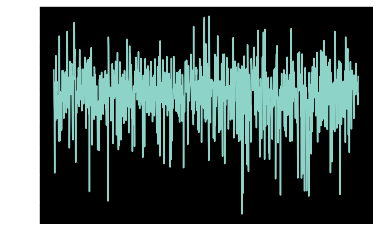

** HMM **
Groups
States 0 have the same emission
States 1 have the same emission
Initial state probability
[0.64344087 0.35655913]


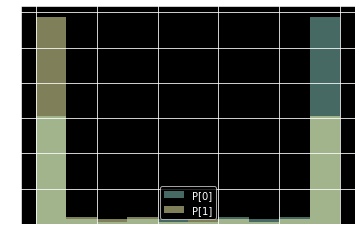

State transition matrix
[[0.759 0.241]
 [0.418 0.582]]



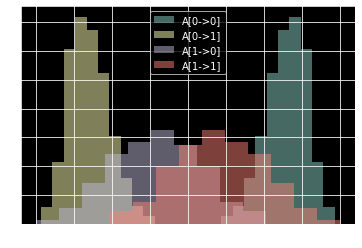

HMM Emission 0
** Univariate Gaussian Emission **
Mean
0.09807941353945503
Variance
0.10876372636031778



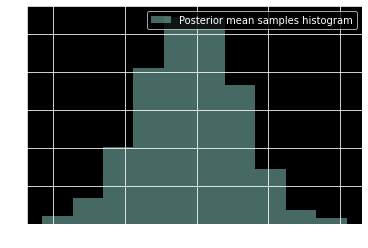

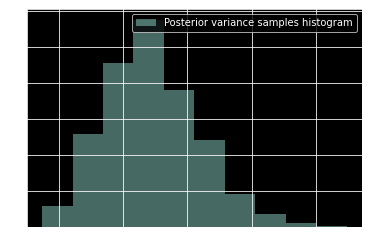

HMM Emission 1
** Univariate Gaussian Emission **
Mean
-0.200717927489205
Variance
0.44963804006152924



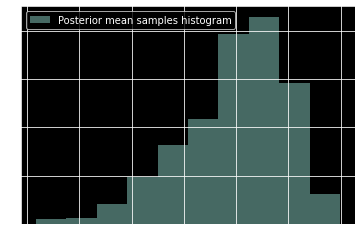

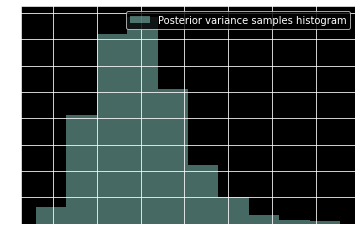

In [62]:
# test hmm with gaussian emissions!
# simulate process
def simulate_hmm(n, A, mean, var):
    states = np.arange(A.shape[0], dtype = int)
    z = np.zeros(n, dtype = int)
    y = np.zeros((n, mean[0].size))
    z[0] = np.random.choice(states)
    y[0] = np.random.normal(mean[z[0]], np.sqrt(var[z[0]]))
    for i in range(1,n):
        z[i] = np.random.choice(states, p = A[z[i-1]])
        y[i] = np.random.normal(mean[z[i]],np.sqrt(var[z[i]]) )
    return y, z


n = 1000
A = np.array([[0.8,0.2],[0.3,0.7]])
mean = np.array([0.1, -0.2])
var = np.array([0.1, 0.4])
y, z = simulate_hmm(n, A, mean, var)
plt.plot(y)
plt.show()

emissions = [uGaussianEmission(), uGaussianEmission()]
uhmm = uHMM(
            emissions = emissions,
            n_gibbs = 1000
            )
uhmm.estimate(y)
uhmm.view(True)

** Univariate Laplace Emission **
Mean
1.0347651477038076
Variance
0.49618849214525995



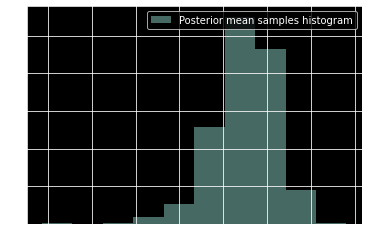

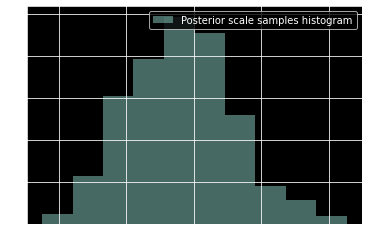

In [7]:
# univariate gaussian

@jit(nopython = True)
def laplace_sample_posterior(x, m, q, b, n_samples=1000, proposal_std=1.0):
    """Metropolis-Hastings sampler for p(mu | x)."""
    
    def log_posterior(mu, x, m, q, b):
        """Log of the posterior density, up to a constant."""
        return -np.sum(np.abs(x - mu)) / b - (mu - m) ** 2 / (2 * q)

    samples = np.zeros(n_samples)
    mu_current = m  # Start at prior mean
    for i in range(n_samples):
        # Propose new sample from Gaussian centered at current value
        mu_proposed = np.random.normal(mu_current, proposal_std)
        # Compute acceptance ratio
        log_p_accept = log_posterior(mu_proposed, x, m, q, b) - log_posterior(mu_current, x, m, q, b)
        # Accept or reject
        if np.log(np.random.rand()) < log_p_accept:
            mu_current = mu_proposed        
        samples[i] = mu_current
    return samples


class uLaplaceEmission(uEmission):
    def __init__(self, n_gibbs:int = 1000, f_burn:float = 0.1, min_points_update = 5):
        
        self.n_gibbs = n_gibbs
        self.f_burn = f_burn
        self.n_gibbs_sim = int(self.n_gibbs*(1+self.f_burn))
        self.min_points_update = min_points_update
        # variables to be computed
        self.var = None
        self.mean = None        
        self.S0aux = None
        self.invV0, self.invV0m0 = None, None
        self.prev_mn, self.prev_Vn = None, None
        self.prev_vn, self.prev_Sn = None, None 
    
    def get_pdf_limits(self, k = 5):
        return self.mean - 5*np.sqrt(self.var), self.mean + 5*np.sqrt(self.var)
    
    def pdf(self, x):
        return np.exp(-0.5*np.power(x-self.mean,2)/self.var)/np.sqrt(2*np.pi*self.var)
        
    def view(self, plot_hist = False):
        print('** Univariate Laplace Emission **')
        print('Mean')
        print(self.mean)
        print('Variance')
        print(self.b)
        print()
        if plot_hist:
            if self.gibbs_mean is not None:
                plt.hist(
                        self.gibbs_mean,
                        density=True,
                        alpha=0.5,
                        label='Posterior mean samples histogram'
                        )
                plt.legend()
                plt.grid(True)
                plt.show()
            if self.gibbs_b is not None:
                plt.hist(
                        self.gibbs_b,
                        density=True,
                        alpha=0.5,
                        label='Posterior scale samples histogram'
                        )
                plt.legend()
                plt.grid(True)
                plt.show()

    def gibbs_initialize(self, y, **kwargs):
        assert y.ndim == 1, "y must be a vector"
        # this will be updated later
        self.mean = 0         
        # Scale samples
        self.gibbs_b = np.zeros(self.n_gibbs_sim) 
        # Mean samples
        self.gibbs_mean = np.zeros(self.n_gibbs_sim)          
        # compute data variance
        self.scale = np.std(y)
        
        # Prior distribution parameters
        self.m0 = 0 # np.mean(y) # mean: prior location (just put it at zero...)
        self.v0 = self.scale**2 # mean: prior covariance        
        
        self.a0 = 2 # infinite variance...
        self.b0 = self.scale   
        
        # initialize
        self.gibbs_mean[0] = self.m0
        self.gibbs_b[0] = self.scale
        # store parameters
        self.prev_mn = self.m0
        self.prev_vn = self.v0
        
        self.prev_an = self.a0
        self.prev_bn = self.b0

    def gibbs_posterior_sample(self, y:np.ndarray, iteration:int, **kwargs):
        '''
        y: current set of observations
        to be called while in sampler
        '''
        assert y.ndim == 1, "y must be a vector"
        assert 0<iteration<self.n_gibbs_sim, "iteration is larger than the number of iterations"
        # no observations in y
        if y.size < self.min_points_update:
            self.gibbs_mean[iteration] = np.random.normal(self.prev_mn, self.prev_vn)
            self.gibbs_b[iteration] = 1 / np.random.gamma(self.prev_an, 1 / self.prev_bn)
        else:
            n = y.size
            # Sample from mean - MH sampler!
            samples = laplace_sample_posterior(y, 
                                              m = self.m0, 
                                              q = self.v0, 
                                              b = self.gibbs_b[iteration-1], 
                                              n_samples=1000, 
                                              proposal_std = 1.0)
            
            mn = np.mean(samples)      
            vn = np.var(samples)
            self.prev_mn = mn
            self.prev_vn = vn
            self.gibbs_mean[iteration] = np.random.normal(mn, vn)
            
            # Sample from variance
            an = self.a0 + n
            bn = self.b0 + np.sum(np.abs(y-self.gibbs_mean[iteration]))
            self.prev_an = an
            self.prev_bn = bn
            self.gibbs_b[iteration] = 1 / np.random.gamma(an, 1 / bn)	


    def gibbs_burn_and_mean(self):
        self.gibbs_mean = self.gibbs_mean[-self.n_gibbs:]
        self.gibbs_b = self.gibbs_b[-self.n_gibbs:]		
        self.mean = np.mean(self.gibbs_mean)
        self.b = np.mean(self.gibbs_b)	
        self.w_norm = np.abs(self.mean / (2*self.b*self.b)) # betting weight
    
    def gibbs_prob(self, y:np.ndarray, iteration:int, **kwargs):
        assert 0<iteration<self.n_gibbs_sim, "iteration is larger than the number of iterations"
        assert y.ndim == 1, "y must be a vector"
        p = np.exp(-np.abs(y-self.gibbs_mean[iteration-1])/self.gibbs_b[iteration-1]) 
        p /= 2*self.gibbs_b[iteration-1]
        return p
    
    def estimate(self, y:np.ndarray, **kwargs):
        # cycle to test individually the inference!
        self.gibbs_initialize(y)
        for i in range(1, self.n_gibbs_sim):
            self.gibbs_posterior_sample(y, i)
        self.gibbs_burn_and_mean()		
    
    def prob(self, y:np.ndarray,  **kwargs):
        # use vectorized function
        assert y.ndim == 1, "y must be a vector"
        return np.exp(-np.abs(y - self.mean) / self.b) / (2*self.b)
    
    def posterior_predictive(self, **kwargs):
        return self.mean, 2*self.b**2
    
    def predict_pi(self, **kwargs):
        return 1
    
# run bayesian inference
y = np.random.laplace(1, 0.5, 1000)
g = uLaplaceEmission()
g.estimate(y)
g.view(True)

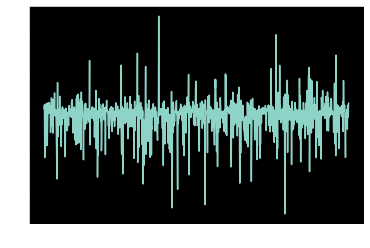

** HMM **
Groups
States 0 have the same emission
States 1 have the same emission
Initial state probability
[0.80749395 0.19250605]


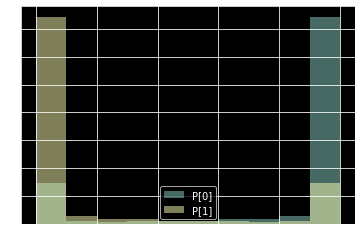

State transition matrix
[[0.754 0.246]
 [0.357 0.643]]



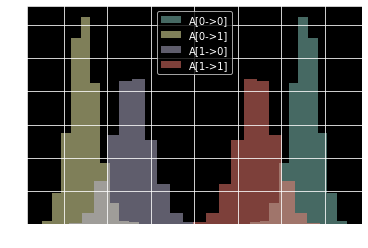

HMM Emission 0
** Univariate Laplace Emission **
Mean
0.10154506294496814
Variance
0.10149713069985285



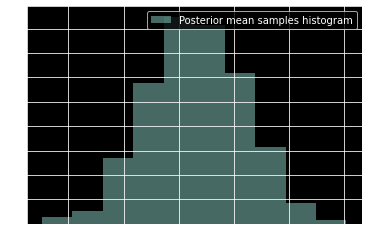

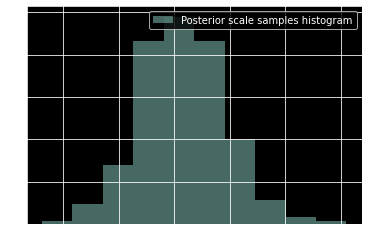

HMM Emission 1
** Univariate Laplace Emission **
Mean
-0.2053703997903266
Variance
0.435487039976162



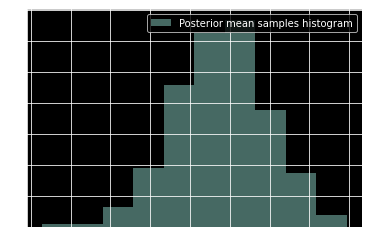

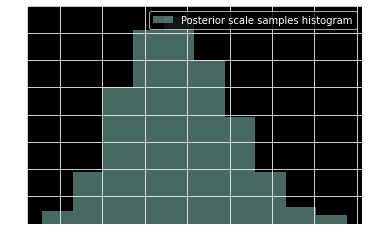

In [8]:
# test hmm with laplace emissions!
# simulate process
def simulate_lhmm(n, A, mean, b):
    states = np.arange(A.shape[0], dtype = int)
    z = np.zeros(n, dtype = int)
    y = np.zeros((n, mean[0].size))
    z[0] = np.random.choice(states)
    y[0] = np.random.laplace(mean[z[0]], b[z[0]])
    for i in range(1,n):
        z[i] = np.random.choice(states, p = A[z[i-1]])
        y[i] = np.random.laplace(mean[z[i]],b[z[i]]) 
    return y, z


n = 1000
A = np.array([[0.8,0.2],[0.3,0.7]])
mean = np.array([0.1, -0.2])
b = np.array([0.1, 0.4])
y, z = simulate_lhmm(n, A, mean, b)
plt.plot(y)
plt.show()

emissions = [uLaplaceEmission(), uLaplaceEmission()]
uhmm = uHMM(
            emissions = emissions,
            n_gibbs = 1000
            )
uhmm.estimate(y)
uhmm.view(True)

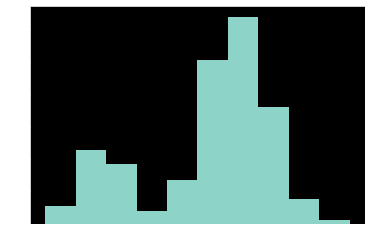

** Univariate Mixture Emission **
Mixtures Probabilities
[0.21705593 0.78294407]



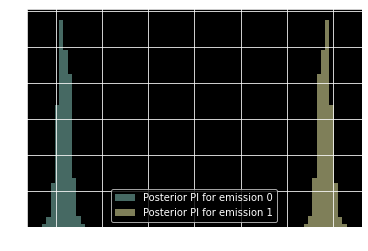


Mixture Emission 0
** Univariate Gaussian Emission **
Mean
-1.01169647169311
Variance
0.09733641575012221



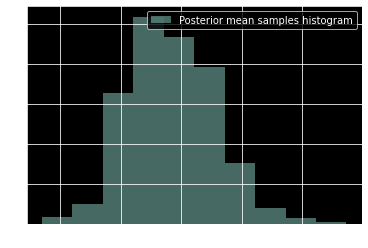

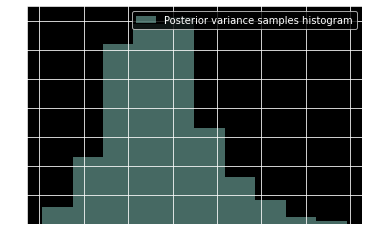

Mixture Emission 1
** Univariate Gaussian Emission **
Mean
0.9955380577518923
Variance
0.20382847345628943



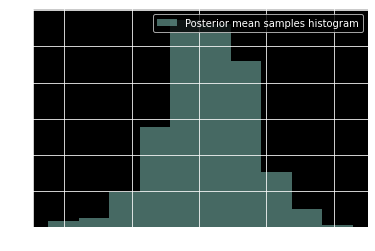

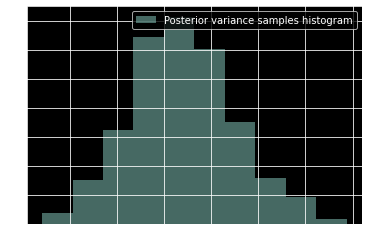

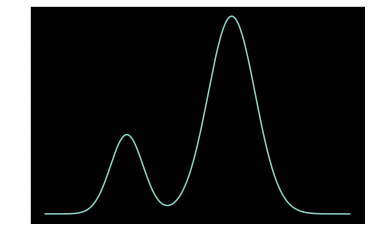

In [9]:
# univariate gaussian misture emission
class uMixtureEmission(uEmission):
    def __init__(self, 
                 emissions:List[uEmission] = [], 
                 n_gibbs:int = 1000, 
                 f_burn:float = 0.1, 
                 min_points_update = 5
                ):
        self.n_gibbs = n_gibbs
        self.f_burn = f_burn
        self.n_gibbs_sim = int(self.n_gibbs*(1+self.f_burn))
        self.min_points_update = min_points_update
        
        self.emissions = emissions
        self.n_emissions = len(self.emissions)

        for emission in self.emissions:
            emission.set_gibbs_parameters(self.n_gibbs, self.f_burn, self.n_gibbs_sim)        
        
        # variables to be computed
        self.pi = None
    # override
    def set_gibbs_parameters(self, n_gibbs, f_burn, n_gibbs_sim = None):
        self.n_gibbs = n_gibbs
        self.f_burn = f_burn
        aux = int(self.n_gibbs*(1+self.f_burn))
        self.n_gibbs_sim = aux if n_gibbs_sim is None else n_gibbs_sim
        for emission in self.emissions:
            emission.set_gibbs_parameters(self.n_gibbs, self.f_burn, self.n_gibbs_sim)  
            
    def view(self, plot_hist = False):
        print('** Univariate Mixture Emission **')
        print('Mixtures Probabilities')
        print(self.pi)
        print()
        if plot_hist:
            if self.gibbs_pi is not None:
                for s in range(self.n_emissions):
                    plt.hist(
                            self.gibbs_pi[:,s],
                            density=True,
                            alpha=0.5,
                            label=f'Posterior PI for emission {s}'
                            )
                plt.legend()
                plt.grid(True)
                plt.show()
        print()
        for s in range(self.n_emissions):
            print(f'Mixture Emission {s}')
            self.emissions[s].view(plot_hist)
        # draw pdf
        # get limits
        x_min = np.inf
        x_max = -np.inf
        for e in self.emissions:
            x_min_, x_max_ = e.get_pdf_limits(k = 5)
            x_min = min(x_min, x_min_)
            x_max = max(x_max, x_max_)
        x_pdf = np.linspace(x_min, x_max, 500)
        pdf = np.zeros_like(x_pdf)
        for s in range(self.n_emissions):
            pdf += self.pi[s]*self.emissions[s].pdf(x_pdf)
        plt.plot(x_pdf, pdf)
        plt.show()
        
    def gibbs_initialize(self, y, **kwargs):
        assert y.ndim == 1, "y must be a vector"        
        # allocate
        self.gibbs_pi = np.zeros((self.n_gibbs_sim, self.n_emissions))
        # initialize to equal probability
        self.gibbs_pi[0] = np.ones(self.n_emissions, dtype = np.float64)
        self.gibbs_pi[0] /= np.sum(self.gibbs_pi[0]) 
        for e in self.emissions:
            e.gibbs_initialize(y)

    def gibbs_posterior_sample(self, y:np.ndarray, iteration:int, **kwargs):
        '''
        y: current set of observations
        to be called while in sampler
        '''
        assert y.ndim == 1, "y must be a vector"
        assert 0<iteration<self.n_gibbs_sim, "iteration is larger than the number of iterations"
        n = y.size
        n_count = np.zeros(self.n_emissions)       
        # sample z
        # 1 - compute probabily of observations with previous
        # step parameters
        aux = np.zeros((n, self.n_emissions))
        for s in range(self.n_emissions):
            # this will use previous iteration parameters!
            p = self.emissions[s].gibbs_prob(y = y, iteration = iteration)
            aux[:,s] = self.gibbs_pi[iteration-1, s]*p                  
        # 2 - sample hidden state
        # this is a hack to sample fast from a multinomial with different probabilities!	  
        aux /= np.sum(aux, axis = 1)[:,None]
        uni = np.random.uniform(0, 1, size = n)
        aux = np.cumsum(aux, axis = 1)
        wrows, wcols = np.where(aux > uni[:,None])
        un, un_idx = np.unique(wrows, return_index = True)	
        z = wcols[un_idx]
        
        # sample from distributions
        for s in range(self.n_emissions):
            # basically, this is the code to sample from a multivariate
            # gaussian but constrained to observations where state=j
            idx = np.where(z==s)[0]	
            self.emissions[s].gibbs_posterior_sample(y[idx], iteration = iteration)
            n_count[s] = idx.size
            
        # update hidden state distribution
        self.gibbs_pi[iteration] = np.random.dirichlet(n_count + 1)

    def gibbs_burn_and_mean(self):
        self.gibbs_pi = self.gibbs_pi[-self.n_gibbs:]
        self.pi = np.mean(self.gibbs_pi, axis = 0)
        for s in range(self.n_emissions):
            self.emissions[s].gibbs_burn_and_mean()
        # compute w_norm!
        mean = 0
        var = 0
        for s in range(self.n_emissions):
            mean += self.pi[s]*self.emissions[s].mean
            var += self.pi[s]*(self.emissions[s].mean**2 + self.emissions[s].mean**2)
        var -= mean*mean
        self.mean = mean
        self.var = var        
        self.w_norm = np.abs(self.mean / self.var)
            
    def gibbs_prob(self, y:np.ndarray, iteration:int, **kwargs):
        assert 0<iteration<self.n_gibbs_sim, "iteration is larger than the number of iterations"
        assert y.ndim == 1, "y must be a vector"
        p = np.zeros(y.size)
        for s in range(self.n_emissions):
            p += self.gibbs_pi[iteration-1, s]*self.emissions[s].gibbs_prob(
                                                                            y = y, 
                                                                            iteration = iteration
                                                                            )
        return p
    
    def estimate(self, y:np.ndarray, **kwargs):
        # cycle to test individually the inference!
        self.gibbs_initialize(y)
        for i in range(1, self.n_gibbs_sim):
            self.gibbs_posterior_sample(y, i)
        self.gibbs_burn_and_mean()
    
    def prob(self, y:np.ndarray,  **kwargs):
        # use vectorized function
        assert y.ndim == 1, "y must be a vector"
        p = np.zeros(y.size)
        for s in range(self.n_emissions):
            p += self.pi[s]*self.emissions[s].prob(y = y)
        return p
    
    def posterior_predictive(self, **kwargs):
        return self.mean, self.var
    
    def predict_pi(self, **kwargs):
        return 1
    
# generate data
def simulate_gmm(n, phi, mean, var):
    # simulate states
    z = np.random.choice(np.arange(phi.size, dtype = int), p = phi, size = n)
    y = np.zeros(n)
    for i in range(n):
        y[i] = np.random.normal(mean[z[i]],np.sqrt(var[z[i]]))
    return y, z

n = 1000
phi = np.array([0.2, 0.8])
mean = np.array([-1, 1])
var = np.array([0.1, 0.2])
y, z = simulate_gmm(n, phi, mean, var)
plt.hist(y, density = True)
plt.show()

emissions = [uGaussianEmission(), uGaussianEmission()]
g = uMixtureEmission(emissions)
g.estimate(y)
g.view(True)

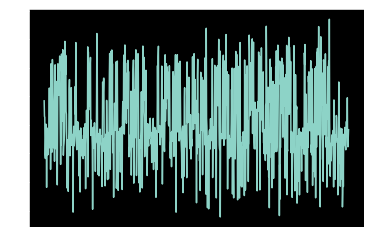

** HMM **
Groups
States 0 have the same emission
States 1 have the same emission
Initial state probability
[0.04502971 0.95497029]


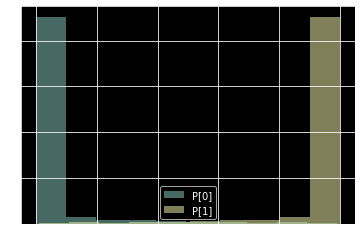

State transition matrix
[[0.822 0.178]
 [0.267 0.733]]



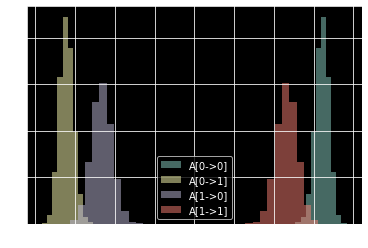

HMM Emission 0
** Univariate Mixture Emission **
Mixtures Probabilities
[0.79976426 0.20023574]



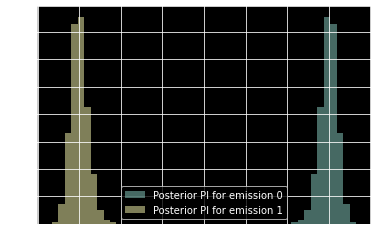


Mixture Emission 0
** Univariate Gaussian Emission **
Mean
-0.5128629360505829
Variance
0.1093619922127782



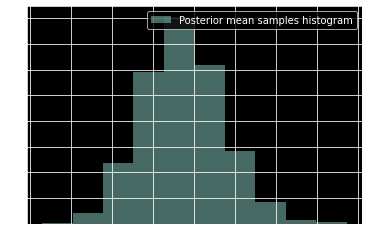

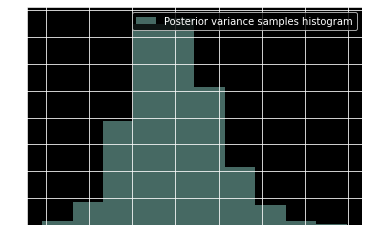

Mixture Emission 1
** Univariate Gaussian Emission **
Mean
-2.032887780502693
Variance
0.2947125575992258



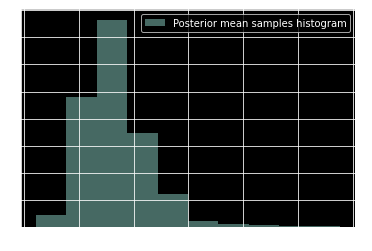

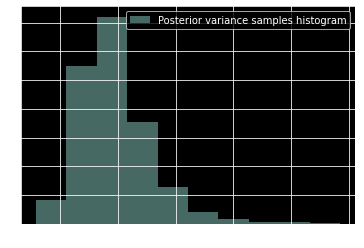

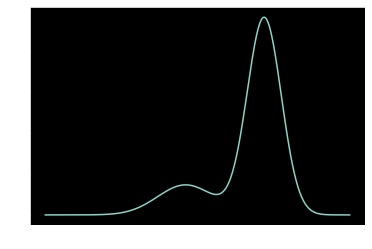

HMM Emission 1
** Univariate Mixture Emission **
Mixtures Probabilities
[0.56015653 0.43984347]



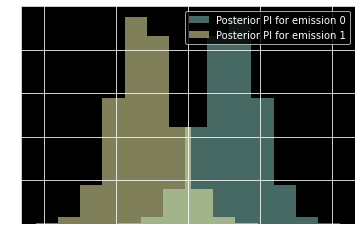


Mixture Emission 0
** Univariate Gaussian Emission **
Mean
2.069305608683352
Variance
0.28461729874306335



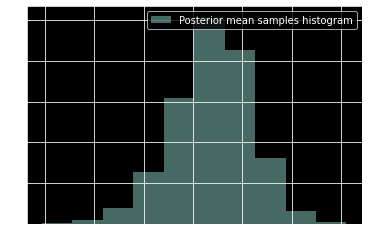

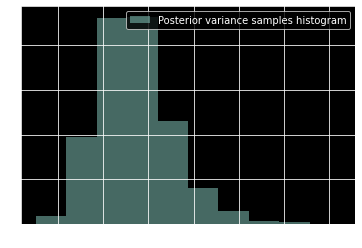

Mixture Emission 1
** Univariate Gaussian Emission **
Mean
0.5154127521541321
Variance
0.2403093035363572



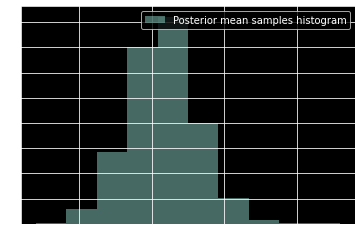

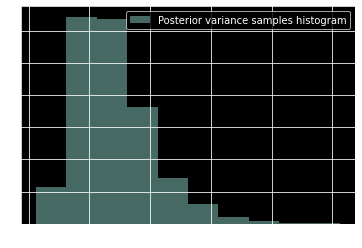

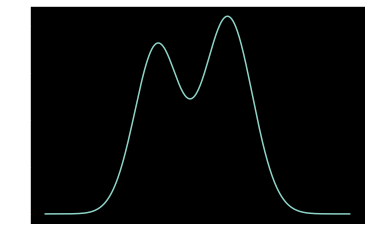

In [10]:
def simulate_gmmhmm(n, A, phi, mean, var):
    states = np.arange(A.shape[0], dtype = int)
    z = np.zeros(n, dtype = int)
    y = np.zeros(n)
    
    z[0] = np.random.choice(states)
    phi_z = np.random.choice(np.arange(phi[z[0]].size), p = phi[z[0]])    
    y[0] = np.random.normal(mean[z[0]][phi_z], np.sqrt(var[z[0]][phi_z]))
    for i in range(1,n):
        z[i] = np.random.choice(states, p = A[z[i-1]])
        phi_z = np.random.choice(np.arange(phi[z[i]].size), p = phi[z[i]])    
        y[i] = np.random.normal(mean[z[i]][phi_z], np.sqrt(var[z[i]][phi_z]))
    return y, z

n = 1000
A = np.array([[0.8,0.2],[0.3,0.7]])
phi = [np.array([0.2, 0.8]), np.array([0.4, 0.6])]
mean = [np.array([-2, -0.5]), np.array([0.5, 2])]
var = [np.array([0.25, 0.1]), np.array([0.1, 0.25])]
y, z = simulate_gmmhmm(n, A, phi, mean, var)
plt.plot(y)
plt.show()

c1_emissions = [uGaussianEmission(), uGaussianEmission()]
emission_1 = uMixtureEmission(c1_emissions)

c2_emissions = [uGaussianEmission(), uGaussianEmission()]
emission_2 = uMixtureEmission(c2_emissions)


emissions = [emission_1, emission_2]
uhmm = uHMM(
            emissions = emissions,
            n_gibbs = 3000
            )
uhmm.estimate(y)
uhmm.view(True)

In [11]:
@jit(nopython = True)
def u_rwnoise_forward(y, m, a):
    n = y.size
    am = 1 - a
    m[0] = y[0]
    for j in range(1, n):
        m[j] = a * y[j] + am * m[j-1]

@jit(nopython = True)
def u_rwnoise_backward(m, mu, q_inf, v):
    n = m.size
    mu[n-1] = np.random.normal(m[n-1], q_inf)
    for j in range(n-2, -1, -1):
        mu[j] = np.random.normal( (m[j]*v + q_inf*mu[j+1]) / (q_inf+v), np.sqrt(v*q_inf/(q_inf+v)) )
                      

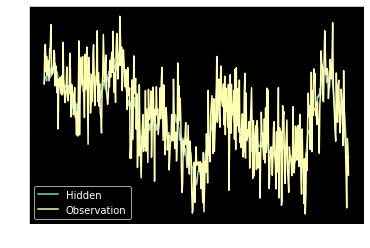

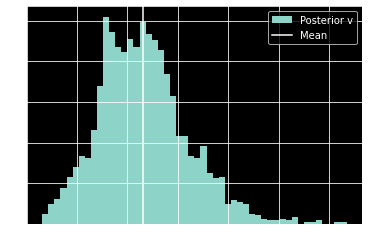

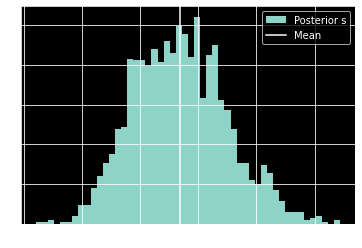

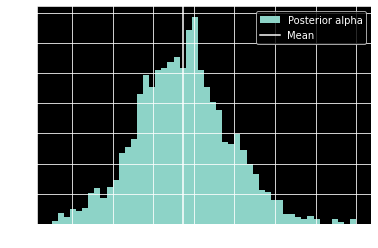

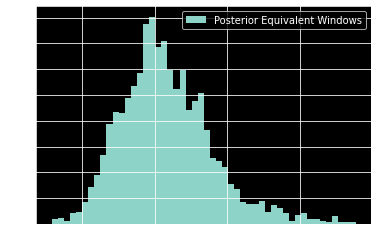

In [12]:
# gibbs sampler!
class uRWNoise:
    def __init__(self, n_gibbs:int = 1000, f_burn:float = 0.1):
        self.n_gibbs = n_gibbs
        self.f_burn = f_burn
        self.n_gibbs_eff = int(n_gibbs * (1+self.f_burn))
    
    def view(self):
        plt.hist(self.v_samples, density = True, bins = 50, label = 'Posterior v')
        plt.axvline(self.v, label = 'Mean')
        plt.legend()
        plt.grid(True)
        plt.show()

        plt.hist(self.s_samples, density = True, bins = 50, label = 'Posterior s')
        plt.axvline(self.s, label = 'Mean')
        plt.legend()
        plt.grid(True)
        plt.show()

        plt.hist(self.alpha_samples, density = True, bins = 50, label = 'Posterior alpha')
        plt.axvline(self.alpha, label = 'Mean')
        plt.legend()
        plt.grid(True)
        plt.show()   

        plt.hist(2 / self.alpha_samples - 1, density = True, bins = 50, label = 'Posterior Equivalent Windows')
        plt.legend()
        plt.grid(True)
        plt.show()           
        
        
    def estimate(self, y, **kwargs):
        if y.ndim == 2:
            assert y.shape[1] == 1, "y must contain a single series"
            y = y[:,0]        
        assert y.ndim == 1, "y must be a vector"
        # some statistics
        y_var = np.var(y)
        
        n = y.size
        # pre allocate
        m = np.zeros(n)
        mu = np.zeros(n)
        
        # q will be considered a constant!
        
        # store samples
        self.v_samples = np.zeros(self.n_gibbs_eff)
        self.s_samples = np.zeros(self.n_gibbs_eff)
        self.alpha_samples = np.zeros(self.n_gibbs_eff)
        self.q_samples = np.zeros(self.n_gibbs_eff)
        
        a_v = 2
        b_v = y_var  / 100
        a_a0_s, a_b0_s = 2, 10
        b_a0_s, b_b0_s = 2, 10
        
        a_s = 2        
        b_s = y_var  / 100
        a_a0_v, a_b0_v = 2, 10
        b_a0_v, b_b0_v = 2, 10
        
        
        self.v_samples[0] = 1 / np.random.gamma(a_v, 1 / b_v) 
        self.s_samples[0] = 1 / np.random.gamma(a_s, 1 / b_s)
        phi = 0.01
        for i in range(1, self.n_gibbs_eff):            
            # compute m, q
            v = self.v_samples[i-1]
            s = self.s_samples[i-1]
            q_inf = 0.5 * (np.sqrt(v*v+4*s*v) - v)
            alpha_inf = (q_inf + v) / (q_inf + v + s)
            # add this as samples
            self.alpha_samples[i-1] = alpha_inf
            self.q_samples[i-1] = q_inf
            # forward
            u_rwnoise_forward(y, m, alpha_inf)
            # backward (store in m to use the same array)
            u_rwnoise_backward(m, mu, q_inf, v)
            # sample parameters
            self.s_samples[i] = 1 / np.random.gamma(a_s + n / 2, 1 / (b_s + 0.5*np.sum(np.power(y-mu, 2))))
            self.v_samples[i] = 1 / np.random.gamma(a_v + (n-1) / 2, 1 / (b_v + 0.5*np.sum(np.power(mu[1:]-mu[:-1], 2))))
            b_s = phi*self.s_samples[i] + (1-phi)*b_s
            b_v = phi*self.v_samples[i] + (1-phi)*b_v
            
        # burn
        self.v_samples = self.v_samples[-self.n_gibbs:]
        self.s_samples = self.s_samples[-self.n_gibbs:]
        
        self.alpha_samples = self.alpha_samples[-self.n_gibbs-1:-1]
        self.q_samples = self.q_samples[-self.n_gibbs-1:-1]
        
        self.v = np.mean(self.v_samples)
        self.s = np.mean(self.s_samples)
        self.alpha = np.mean(self.alpha_samples)
        self.w_norm = np.sqrt(y_var) / self.s

    def get_weight(
                self, 
                y:np.ndarray, 
                normalize = True,
                **kwargs
                ):
        '''
        compute betting weight given an input sequence
        y: numpy (n,p) array with a sequence
            each point is a joint observations of the variables
        l: integer to filter recent data in y -> y=y[-l:]
        returns:
            w: numpy (p,) array with weights to allocate to each asset
            in y
        '''
        if y.ndim == 2:
            assert y.shape[1] == 1, "y must contain a single series"
            y = y[:,0]        
        assert y.ndim == 1, "y must be a vector"        
        if y.size<200:
            return 0
        n = y.size
        m = np.zeros(n)
        u_rwnoise_forward(y, m, self.alpha)
        w = m[-1] / self.s        
        if normalize:
            w /= self.w_norm
        return np.atleast_1d(w)        
        
        
        
# simulate random walk with noise (check notes)
v = 0.05 # hidden state transition variance
s = 1 # sigma squared (observations variance)

n = 500
# simulate
mu = np.zeros(n)
x = np.zeros(n)
for i in range(1, n):
    mu[i] = np.random.normal(mu[i-1], np.sqrt(v))
    x[i] = np.random.normal(mu[i], np.sqrt(s))
plt.plot(mu, label = 'Hidden')
plt.plot(x, label = 'Observation')
plt.legend()
plt.show()        
        
rwnoise = uRWNoise(n_gibbs = 2000)
rwnoise.estimate(x)
rwnoise.view()

In [13]:
import math

In [14]:
@jit(nopython = True)
def u_laplace_rwnoise_forward(y, m, q, v, b):
    n = y.size
    m[0] = y[0]
    q[0] = v # start with a small value
    count_zeros = 0
    for j in range(1, n):
        # propagate forward
        q_ = q[j-1] + v
        m_ = m[j-1]
        
        t1 = np.sqrt(q_/(2*b*b))
        t2 = (y[j]-m_)/np.sqrt(2*q_)
        psi_m = math.erfc(t1-t2)
        psi_p = math.erfc(t1+t2)
        # normally this just happens at algorithm start..
        if psi_m == 0 and psi_p == 0:
            d = 0
            D = 0
        else:
            # delta
            d = (psi_m - np.exp(4*t1*t2)*psi_p ) 
            d /= (psi_m + np.exp(4*t1*t2)*psi_p)

            # Delta
            aux = (np.exp(2*t1*t2)*psi_p + np.exp(-2*t1*t2)*psi_m)
            D = 4*psi_m*psi_p / np.power(aux,2)
            D -= np.sqrt(8*b*b/(np.pi*q_)) * np.exp(-(t1*t1+t2*t2)) / aux
        m[j] = m_ + (q_/b)*d   
        q[j] = q_ + np.power(q_/b,2)*D 

@jit(nopython = True)
def u_laplace_rwnoise_backward(m, mu, q, v):
    n = m.size
    mu[n-1] = np.random.normal(m[n-1], q[n-1])
    for j in range(n-2, -1, -1):
        mu[j] = np.random.normal( (m[j]*v + q[j+1]*mu[j+1]) / (q[j+1]+v), np.sqrt(v*q[j+1]/(q[j+1]+v)) )
         

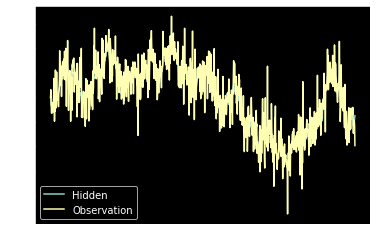

True:  0.5 2


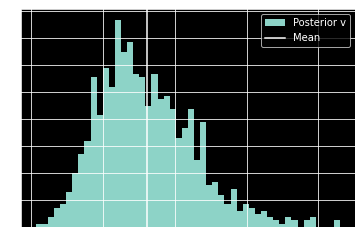

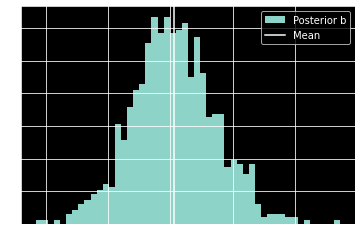

In [15]:
# gibbs sampler!
class uLaplaceRWNoise:
    def __init__(self, n_gibbs:int = 1000, f_burn:float = 0.1):
        self.n_gibbs = n_gibbs
        self.f_burn = f_burn
        self.n_gibbs_eff = int(n_gibbs * (1+self.f_burn))
    
    def view(self):
        plt.hist(self.v_samples, density = True, bins = 50, label = 'Posterior v')
        plt.axvline(self.v, label = 'Mean')
        plt.legend()
        plt.grid(True)
        plt.show()

        plt.hist(self.b_samples, density = True, bins = 50, label = 'Posterior b')
        plt.axvline(self.b, label = 'Mean')
        plt.legend()
        plt.grid(True)
        plt.show()
    
    
    def estimate(self, y, **kwargs):
        if y.ndim == 2:
            assert y.shape[1] == 1, "y must contain a single series"
            y = y[:,0]        
        assert y.ndim == 1, "y must be a vector"  
        
        # some statistics
        y_var = np.var(y)
        
        n = y.size
        # pre allocate
        m = np.zeros(n)
        q = np.zeros(n)
        mu = np.zeros(n)
        
        # q will be considered a constant!
        
        # store samples
        self.v_samples = np.zeros(self.n_gibbs_eff)
        self.b_samples = np.zeros(self.n_gibbs_eff)
        
        self.alpha_samples = np.zeros(self.n_gibbs_eff)
        self.q_samples = np.zeros(self.n_gibbs_eff)
        
        a_v = 2
        b_v = y_var

        a_b = 2        
        b_b = y_var
    
        self.v_samples[0] = 1 / np.random.gamma(a_v, 1 / b_v) 
        self.b_samples[0] = 1 / np.random.gamma(a_b, 1 / b_b)
        phi = 0.5
        for i in range(1, self.n_gibbs_eff):            
            # compute m, q
            v = self.v_samples[i-1]
            b = self.b_samples[i-1]
            u_laplace_rwnoise_forward(y, m, q, v, b)
            u_laplace_rwnoise_backward(m, mu, q, v)    
            self.b_samples[i] = 1 / np.random.gamma(n, 1 / (np.sum(np.abs(y-mu))))
            self.v_samples[i] = 1 / np.random.gamma((n-1) / 2, 1 / (0.5*np.sum(np.power(mu[1:]-mu[:-1], 2))))
            
        # burn
        self.v_samples = self.v_samples[-self.n_gibbs:]
        self.b_samples = self.b_samples[-self.n_gibbs:]
        self.q_samples = self.q_samples[-self.n_gibbs-1:-1]
        self.v = np.mean(self.v_samples)
        self.b = np.mean(self.b_samples)
        s = 2*self.b*self.b
        self.qinf = 0.5 * (np.sqrt(self.v*self.v+4*s*self.v) - self.v)
        self.w_norm = np.sqrt(y_var) / (2*self.b**2)

    def get_weight(
                self, 
                y:np.ndarray, 
                normalize = True,
                **kwargs
                ):
        '''
        compute betting weight given an input sequence
        y: numpy (n,p) array with a sequence
            each point is a joint observations of the variables
        l: integer to filter recent data in y -> y=y[-l:]
        returns:
            w: numpy (p,) array with weights to allocate to each asset
            in y
        '''
        if y.ndim == 2:
            assert y.shape[1] == 1, "y must contain a single series"
            y = y[:,0]        
        assert y.ndim == 1, "y must be a vector"        
        if y.size<200:
            return 0
        n = y.size
        m = np.zeros(n)
        q = np.zeros(n)
        u_laplace_rwnoise_forward(y, m, q, self.v, self.b)
        w = m[-1] / (2*self.b**2)        
        if normalize:
            w /= self.w_norm
        return np.atleast_1d(w)            
        
        
v = 0.5 # hidden state transition variance
b = 2 # noise laplace scale 

n = 1000
# simulate
mu = np.zeros(n)
x = np.zeros(n)
for i in range(1, n):
    mu[i] = np.random.normal(mu[i-1], np.sqrt(v))
    x[i] = np.random.laplace(mu[i], b)
plt.plot(mu, label = 'Hidden')
plt.plot(x, label = 'Observation')
plt.legend()
plt.show()
        
        
rwnoise = uLaplaceRWNoise(n_gibbs = 1000)
rwnoise.estimate(x)
print('True: ', v, b)
rwnoise.view()


dict_keys(['XP', 'EO', 'CF', 'GX', 'Z ', 'ST', 'IB', 'ES', 'NQ', 'PT', 'TP'])


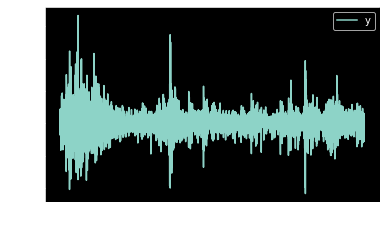

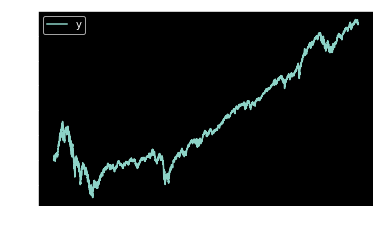

In [7]:
# test on STM with real data
import stm
import pickle
import pandas as pd
data = {}
filepath = 'indexes_data.pkl'
#filepath = 'fi_data.pkl'
#filepath = 'comm_data.pkl'

# load from pickle
with open(filepath, 'rb') as inp:
    tmp = pickle.load(inp)
    data.update(tmp) 
print(data.keys())
data = data['NQ']
data.columns = data.columns.droplevel(1)
data = data[[data.columns[0]]].dropna().pct_change().dropna()
data.columns = ['y']
data.index = pd.to_datetime(data.index)
data.plot()
plt.show()
np.cumsum(data, axis = 0).plot()
plt.show()

100%|████████████████████████████████████████████████████████████████████████████████████| 3/3 [02:37<00:00, 52.37s/it]


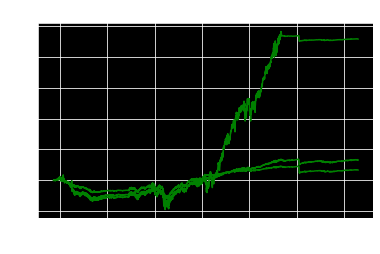

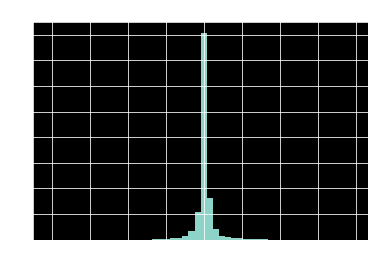

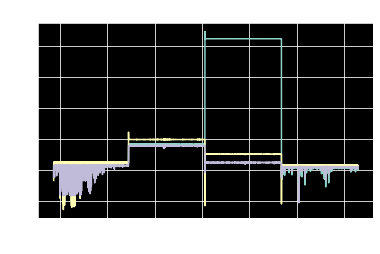

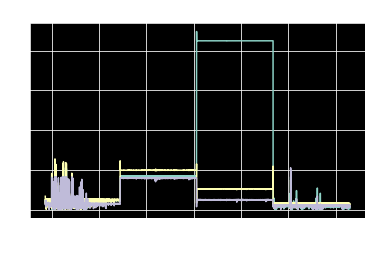

** REJECT STRATEGY **


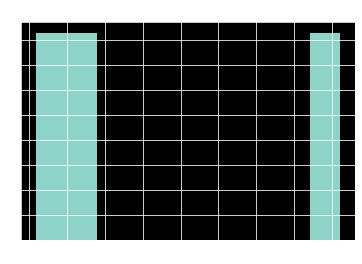

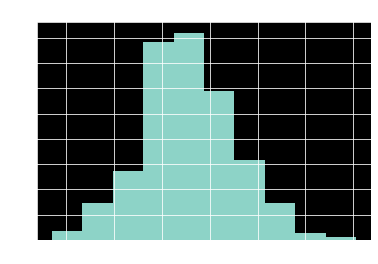


** PERFORMANCE SUMMARY **

Return:  0.014206861569104704
Standard deviation:  0.04525433605353617
Sharpe:  0.31393370907702406



In [8]:
dataset = stm.Dataset()
dataset.add('dataset', data)
model_pipe = stm.ModelPipe()

emissions = [uGaussianMeanEmission(), uGaussianMeanEmission()]
uhmm = uHMM(
            emissions = emissions,
            n_gibbs = 2000,
            pred_l = 100
            )

model_pipe.add('dataset', model = uhmm)
paths = stm.cvbt(
        dataset = dataset, 
        model_pipe = model_pipe,
        n_paths = 3
     )

paths.post_process()

In [84]:
import time
class A:
    # __slots__ = ['z', 'n_iter']  # Define the attributes ahead of time
    def __init__(self):
        self.n_iter = 1
        self.z = None
        
    def set_iter(self, n_iter):
        self.n_iter = n_iter
    def sampler_initialize(self):
        self.z = np.zeros(self.n_iter)

    def sample(self, y, i):
        self.z[i] = np.random.normal()
        
        
class B:
    # __slots__ = ['z', 'n_iter']  # Define the attributes ahead of time
    def __init__(self):
        self.n_iter = 1
        self.z = None
        
    def set_iter(self, n_iter):
        self.n_iter = n_iter
    
    def sampler_initialize(self):
        self.z = np.zeros(self.n_iter)

    def sample(self, y, z, i):
        z[i] = np.random.normal()        
        


def sampler(y, n_iter, class_instance):
    class_instance.set_iter(n_iter)
    class_instance.sampler_initialize()
    
    x = np.zeros(n_iter)
    
    x[0] = 0
    for i in range(1, n_iter):
        x[i] = np.random.normal() # just an example
        class_instance.sample(y, i)
    return x

def sampler_2(y, n_iter, class_instance):
    class_instance.set_iter(n_iter)
    class_instance.sampler_initialize()
    
    x = np.zeros(n_iter)
    z = class_instance.z
    x[0] = 0
    for i in range(1, n_iter):
        x[i] = np.random.normal() # just an example
        z[i] = np.random.normal()
        # class_instance.sample(y, i)
    return x

def sampler_3(y, n_iter, class_instance):
    class_instance.set_iter(n_iter)
    class_instance.sampler_initialize()
    
    x = np.zeros(n_iter)
    z = class_instance.z
    x[0] = 0
    for i in range(1, n_iter):
        x[i] = np.random.normal() # just an example
        class_instance.sample(y, z, i)
    return x

y = np.random.normal(0,1,1000)
n_iter = 100000
class_instance = A()
class_instance_2 = B()

print(class_instance.__dict__)
print(sdfsdf)

s = time.time()
sampler(y, n_iter, class_instance)
print('Elapsed time: ', time.time()-s)
s = time.time()
sampler_2(y, n_iter, class_instance)
print('Elapsed time: ', time.time()-s)
s = time.time()
sampler_3(y, n_iter, class_instance_2)
print('Elapsed time: ', time.time()-s)

# this is a minimal example of the problem
# if i write the array z inside function sampler 
# instead of being inside the class the 
# function runs much faster



{'n_iter': 1, 'z': None}


NameError: name 'sdfsdf' is not defined

In [ ]:
dataset = stm.Dataset()
dataset.add('dataset', data)
model_pipe = stm.ModelPipe()

c1_emissions = [uGaussianEmission(), uGaussianEmission()]
emission_1 = uMixtureEmission(c1_emissions)

c2_emissions = [uGaussianEmission(), uGaussianEmission()]
emission_2 = uMixtureEmission(c2_emissions)

emissions = [emission_1, emission_2]
uhmm = uHMM(
            emissions = emissions,
            n_gibbs = 2000
            )

model_pipe.add('dataset', model = uhmm)
paths = stm.cvbt(
        dataset = dataset, 
        model_pipe = model_pipe,
        n_paths = 3
        )

paths.post_process()

In [ ]:
dataset = stm.Dataset()
dataset.add('dataset', data)
model_pipe = stm.ModelPipe()

c1_emissions = [uGaussianEmission(), uGaussianEmission(), uGaussianEmission()]
emission_1 = uMixtureEmission(c1_emissions)

c2_emissions = [uGaussianEmission(), uGaussianEmission(), uGaussianEmission()]
emission_2 = uMixtureEmission(c2_emissions)

emissions = [emission_1, emission_2]
uhmm = uHMM(
            emissions = emissions,
            n_gibbs = 2000
            )

model_pipe.add('dataset', model = uhmm)
paths = stm.cvbt(
        dataset = dataset, 
        model_pipe = model_pipe,
        n_paths = 3
        )

paths.post_process()